In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import sklearn
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from random import sample
import matplotlib
import pytorch_lightning as pl
matplotlib.rcParams['figure.figsize'] = (3, 3)

%matplotlib inline

In [2]:
# Creating labels and splitting data
buildings = pd.DataFrame(os.listdir('data/buildings'), columns=['number'])
forest = pd.DataFrame(os.listdir('data/forest'), columns=['number'])
glacier = pd.DataFrame(os.listdir('data/glacier'), columns=['number'])
#street = pd.DataFrame(os.listdir('data/street'), columns=['number'])
#mountain = pd.DataFrame(os.listdir('data/mountain'), columns=['number'])
#sea = pd.DataFrame(os.listdir('data/sea'), columns=['number'])

buildings['name_label'] = 'buildings'
forest['name_label'] = 'forest'
glacier['name_label'] = 'glacier'
#street['name_label'] = 'street'
#mountain['name_label'] = 'mountain'
#sea['name_label'] = 'sea'

name_label_to_num = {
    'buildings':0,
    'forest':1,
    'glacier':2,
    'street':3,
    'mountain':4,
    'sea':5,
}

buildings['label'] = buildings['name_label'].apply(lambda name: name_label_to_num[name])
forest['label'] = forest['name_label'].apply(lambda name: name_label_to_num[name])
glacier['label'] = glacier['name_label'].apply(lambda name: name_label_to_num[name])
#street['label'] = street['name_label'].apply(lambda name: name_label_to_num[name])
#mountain['label'] = mountain['name_label'].apply(lambda name: name_label_to_num[name])
#sea['label'] = sea['name_label'].apply(lambda name: name_label_to_num[name])

i,j = 96, 128
train = pd.concat([buildings[:i], forest[:i], glacier[:i]])#, street[:i], mountain[:i], sea[:i]])
valid = pd.concat([buildings[i:j], forest[i:j], glacier[i:j]])#, street[i:j], mountain[i:j], sea[i:j]])
test = pd.concat([buildings[j:], forest[j:], glacier[j:]])#, street[j:], mountain[j:], sea[j:]])
train

,number,name_label,label
0,0.jpg,buildings,0
1,10006.jpg,buildings,0
2,1001.jpg,buildings,0
3,10014.jpg,buildings,0
4,10018.jpg,buildings,0
...,...,...,...
91,10664.jpg,glacier,2
92,10670.jpg,glacier,2
93,10689.jpg,glacier,2
94,10690.jpg,glacier,2


In [3]:
class ImageDataset(Dataset):
    
    def __init__(self, df, directory, transform=None):
        self.df = df
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name_label = self.df.iloc[idx]['name_label']
        label = self.df.iloc[idx]['label']
        number = self.df.iloc[idx]['number']
        target_iamge = torch.ones(3,150,150)
        loaded_image = torchvision.io.read_image(f"{self.directory}/{name_label}/{number}")
        target_iamge[:,:loaded_image.shape[1],:loaded_image.shape[2]] = loaded_image
        return target_iamge, label


def show(img, title=None):
    img = img.detach()
    img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(np.asarray(img))
    if title:
        plt.title(title)
    plt.show()

In [4]:
train_dataset = ImageDataset(train, 'data')
valid_dataset = ImageDataset(valid, 'data')
test_dataset = ImageDataset(test, 'data')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test))

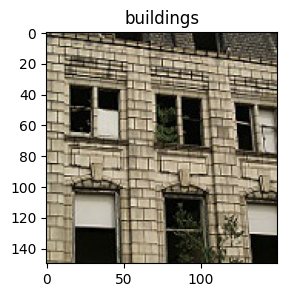

In [5]:
for idx in sample(list(train.index) ,1):
    a = train.iloc[idx]
    show(torchvision.io.read_image(f"data/{a['name_label']}/{a['number']}"), a['name_label'])

In [6]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam


class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=7, stride=1, padding=2)
        
        self.fc1 = nn.Linear(147968 , 1024)
        self.fc2 = nn.Linear(1024 , 6)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2,2)


    def forward(self, x):
        x = self.relu((self.conv1(x))) 
        x = self.relu((self.conv2(x))) 
        x = self.pool(x)
        
        x = self.relu((self.conv3(x)))  
        x = self.relu((self.conv4(x))) 
        x = self.pool(x)
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        output = self.fc2(x)
        
        return output
    
model = ConvolutionalNetwork()
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [7]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


KeyboardInterrupt



In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(valid_dataloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        print(loss)

        
        # print statistics
print('Finished Validation')

In [ ]:
"""
tensor(1.1278, grad_fn=<NllLossBackward0>)
tensor(1.4282, grad_fn=<NllLossBackward0>)

tensor(0.9949, grad_fn=<NllLossBackward0>)
tensor(1.2993, grad_fn=<NllLossBackward0>)

tensor(0.5351, grad_fn=<NllLossBackward0>)
tensor(0.7484, grad_fn=<NllLossBackward0>)
"""

In [ ]:
loss

In [ ]:
torch.save(model.state_dict(), 'model')

In [ ]:
class LightningConvolutionalNetwork(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.loss_functions = nn.CrossEntropyLoss()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=7, stride=1, padding=2)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2,2) 
        
        self.fc1 = nn.Linear(147968 , 1024)
        self.fc2 = nn.Linear(1024 , 6)
        

    def forward(self, x):
        x = self.relu((self.conv1(x))) 
        x = self.relu((self.conv2(x))) 
        x = self.pool(x)
        
        x = self.relu((self.conv3(x)))  
        x = self.relu((self.conv4(x))) 
        x = self.pool(x)
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        output = self.fc2(x)
        
        return output

    def share_step(self, batch):
        x, y  = batch
        y_pred = self(x)
        loss  = loss_functions(y, y_pred)
        return loss, y, y_pred

    def training_step(self, batch, batch_nb):
        loss, y, y_pred = self.share_step(batch)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        loss, y, y_pred = self.step(batch)
        return {'val_loss': loss}

    def test_step(self, batch, batch_nb):
        x, _ = batch
        y_pred = self(x)
        return {'y_pred': y_pred}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(lr=self.learning_rate)
        return optimizer